# Source Sheet

A Source Sheet: an infinite row of sources along one line. Similar to a vortex sheet 

In [2]:
import numpy
import math
from matplotlib import pyplot

#embed the figures 
%matplotlib inline 

In [3]:
N= 100 
x_start, x_end = -1.0, 1.0 
y_start, y_end = -1.5, 1.5
x = numpy.linspace(x_start,x_end, N)
y = numpy.linspace(y_start, y_end, N)
X, Y = numpy.meshgrid(x,y)

In [4]:
# freestream speed 
u_inf = 1.0 

# calculate the velocity components due to the freestream 
u_freestream = u_inf*numpy.ones((N,N), dtype = 'float')
v_freestream = numpy.zeros((N,N), dtype ='float')

### Finite Number of Sources along a line 

We will first consider this case 

We will create classes again 

In [5]:
class Source:
    """
    Contains information related to a source/sink.
    """
    def __init__(self, strength, x, y):
        """
        Sets the location and strength of the singularity.
        
        Parameters
        ----------
        strength: float
            Strength of the source/sink.
        x: float
            x-coordinate of the source/sink.
        y: float
            y-coordinate of the source/sink.
        """
        self.strength = strength
        self.x, self.y = x, y

    def velocity(self, X, Y):
        """
        Computes the velocity field generated by the source/sink.
        
        Parameters
        ----------
        X: 2D Numpy array of floats
            x-coordinate of the mesh points.
        Y: 2D Numpy array of floats
            y-coordinate of the mesh points.
        """
        self.u = self.strength/(2*math.pi)*(X-self.x)/((X-self.x)**2+(Y-self.y)**2)
        self.v = self.strength/(2*math.pi)*(Y-self.y)/((X-self.x)**2+(Y-self.y)**2)

    def stream_function(self, X, Y):
        """
        Computes the stream-function generated by the source/sink.
        
        Parameters
        ----------
        X: 2D Numpy array of floats
            x-coordinate of the mesh points.
        Y: 2D Numpy array of floats
            y-coordinate of the mesh points.
        """
        self.psi = self.strength/(2*math.pi)*numpy.arctan2((Y-self.y), (X-self.x))


We will use this code to to create as many sources that we want. We are going to pick N_source 

In [6]:
N_sources = 11 
strength = 5.0 
strength_source = strength/N_sources 
x_source = numpy.zeros(N_sources, dtype='float')
y_source = numpy.linspace(-1.0, 1.0, N_sources)

#create a source line (numpy array of source objects)
sources = numpy.empty(N_sources, dtype =object)
for i in range(N_sources):
    sources[i]= Source(strength_source, x_source[i], y_source[i]) 
    sources[i].velocity(X,Y)
    
#Super position of all sources to the free-stream flow 
u = u_freestream.copy()
v = v_freestream.copy()
for source in sources:
    u +=source.u
    v +=source.v 

In [7]:

N_sources = 11
strength = 5.0 
strength_source = strength/N_sources    
x_source = numpy.zeros(N_sources, dtype=float) 
y_source = numpy.linspace(-1.0, 1.0, N_sources) 

# create a source line (Numpy array of Source objects)
sources = numpy.empty(N_sources, dtype=object)
for i in range(N_sources):
    sources[i] = Source(strength_source, x_source[i], y_source[i])
    sources[i].velocity(X, Y)

# superposition of all sources to the free-stream flow
u = u_freestream.copy()
v = v_freestream.copy()
for source in sources:
    u += source.u
    v += source.v

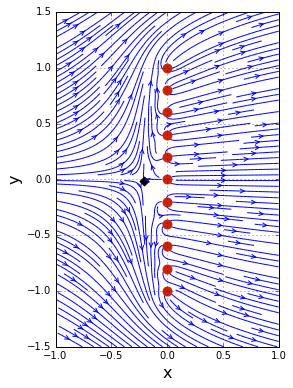

In [8]:
# plot the streamlines
size = 4
pyplot.figure(figsize=(size, (y_end-y_start)/(x_end-x_start)*size))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.streamplot(X, Y, u, v,
                  density=2, linewidth=1, arrowsize=1, arrowstyle='->')
# plot the sources
pyplot.scatter(x_source, y_source,
               color='#CD2305', s=80, marker='o')
# compute the velocity magniture and indices of the stagnation point
# note: the stagnation point is approximated as the point with the smallest velocity magnitude
magnitude = numpy.sqrt(u**2 + v**2)
j_stagn, i_stagn = numpy.unravel_index(magnitude.argmin(), magnitude.shape)
# plot the stagnation point
pyplot.scatter(x[i_stagn], y[j_stagn],
               color='black', s=40, marker='D')
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end);


## Infinite line of sources 

source sheet: an infinite collection of side-by-side sources of infinitesimal equal strength distributed along a given past 

We are going to use SciPy! Which includes a module called integrate. 

In [9]:
from scipy import integrate

We are going to be using a function **quad(func,a,b)** which is included in the module integrate. It evaluate the definite integral of the function func between a and b 

func is a Python function which we have learned how to write using a def command. But we will learn a new way called the lambda statement. 

lambda statement is a single expression that returns a value (but without a return statement), it is often called an anonymous function because we don't need to give it a name. 

We are going to give it a shot with the function $x^2$

In [10]:
print(integrate.quad(lambda x: x**2, 0.0, 1.0))

(0.33333333333333337, 3.700743415417189e-15)


The lambda statement worked because we did not have to define the function before and didn't have to give it a name. 

The **quad()** function returns a list, the first element being the result of the integral, and the second being an estimate of the error. If you want tp know the value of the definite integral, you need to specify the index [0]. 

The lambda function can accept more than one argument...

In [11]:
a =3.0
print(integrate.quad(lambda x, a: a*x**2, 0.0, 1.0, args=a))
b = 2.0 
print(integrate.quad(lambda x, a, b: a*b*x**2, 0.0, 1.0, args=(a,b)))

(1.0, 1.1102230246251565e-14)
(2.0, 2.220446049250313e-14)


The result from the integral calculated by **quad** is a float. It would have to loop over our domain to compute the integral at each point. THIS IS EXPENSIVE! We can use **numpy.vectorize()** that will allow us to mkae a vectorized function that takes Numpy arrays and returns a Numpy array! 

In [12]:
sigma = 2.0   # strength of the source-sheet

# boundaries of the source-sheet
y_min, y_max = -1.0, 1.0

# create the anonymous functions
integrand_u = lambda s, x, y: x / (x**2 + (y - s)**2)
integrand_v = lambda s, x, y: (y - s) / (x**2 + (y - s)**2)

# create a dummy function to vectorize
def integration(x, y, integrand):
    return integrate.quad(integrand, y_min, y_max, args=(x, y))[0]

vec_integration = numpy.vectorize(integration)

# compute the velocity field generated by the source-sheet
u_sheet = sigma / (2.0 * numpy.pi) * vec_integration(X, Y, integrand_u)
v_sheet = sigma / (2.0 * numpy.pi) * vec_integration(X, Y, integrand_v)

# superposition of the source-sheet to the uniform flow
u = u_freestream + u_sheet
v = v_freestream + v_sheet

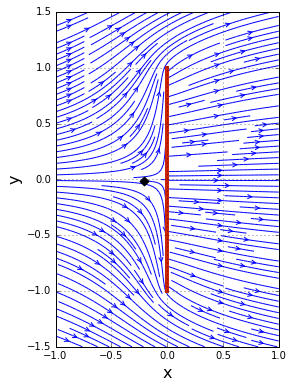

In [13]:
# plot the streamlines 
size =4 
pyplot.figure(figsize = (size, (y_end-y_start)/(x_end-x_start)*size))
pyplot.grid()
pyplot.xlabel('x',fontsize = 16)
pyplot.ylabel('y', fontsize = 16)
pyplot.streamplot(X,Y,u,v,density =2, linewidth =1, arrowsize = 1, arrowstyle = '->')

#plot the source sheet 
pyplot.axvline(0.0, (y_min-y_start)/(y_end-y_start), (y_max-y_start)/(y_end-y_start),
               color = '#CD2305', linewidth = 4)

# compute the velocity magnitude and indices of the stagnation points 
# note: the stagnation point is approximated as the point with the smallest velocity magnitude 
magnitude = numpy.sqrt(u**2 + v**2)
j_stagn, i_stag = numpy.unravel_index(magnitude.argmin(), magnitude.shape)

#plot the stagnation point 
pyplot.scatter(x[i_stagn], y[j_stagn], color= 'black', s= 40, marker = 'D')
pyplot.xlim(x_start,x_end)
pyplot.ylim(y_start, y_end);

In [14]:
x[i_stagn]

-0.21212121212121204

In [15]:
y[j_stagn]

-0.015151515151515138